## Target Validation


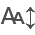

In [8]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import sys
from itables import init_notebook_mode
from utils import show
import itables.options as opt
from pathlib import Path

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

with h5py.File(REPO / "policyengine_uk_local_areas" / "weights.h5", "r") as f:
    weights = f["weight"][:]

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_local_areas.loss import create_constituency_target_matrix, create_national_target_matrix

constituency_target_matrix, constituency_actuals = create_constituency_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)
constituencies_2024 = pd.read_csv(REPO / "policyengine_uk_local_areas" / "constituencies_2024.csv")

constituency_wide = weights @ constituency_target_matrix
constituency_wide.index = constituencies_2024.code.values
constituency_wide["name"] = constituencies_2024.name.values

constituency_results = pd.melt(constituency_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_actuals.index = constituencies_2024.code.values
constituency_actuals["name"] = constituencies_2024.name.values
constituency_actuals_long = pd.melt(constituency_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_target_validation = pd.merge(constituency_results, constituency_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
constituency_target_validation.drop("name_actual", axis=1, inplace=True)
constituency_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

constituency_target_validation["error"] = constituency_target_validation["estimate"] - constituency_target_validation["target"]
constituency_target_validation["abs_error"] = constituency_target_validation["error"].abs()
constituency_target_validation["rel_abs_error"] = constituency_target_validation["abs_error"] / constituency_target_validation["target"]

### Calibration check:
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [9]:
constituency_target_validation.sort_values("rel_abs_error")

index                              name  \
7994   E14001257            Greenwich and Woolwich   
8037   E14001300                      Ilford North   
8006   E14001269       Harrogate and Knaresborough   
2942   E14001405                North West Norfolk   
10623  E14001286       Heywood and Middleton North   
...          ...                               ...   
366    E14001429                             Poole   
99     E14001162              Chesham and Amersham   
109    E14001172  Cities of London and Westminster   
197    E14001260      Hackney South and Shoreditch   
238    E14001301                      Ilford South   

                                         metric      estimate        target  \
7994   hmrc/employment_income/count/15000_20000  1.583421e+03  1.583422e+03   
8037   hmrc/employment_income/count/15000_20000  1.685667e+03  1.685663e+03   
8006   hmrc/employment_income/count/15000_20000  1.510314e+03  1.510319e+03   
2942                                  age/20_30  8.197971e+03  8.198000e+03   
10623  hmrc/employment_income/count/30000_40000  6.673801e+03  6.673777e+03   
...                                         ...           ...           ...   
366                    hmrc/total_income/amount  9.482040e+09  6.592000e+09   
99                     hmrc/total_income/amount  1.314473e+10  8.427000e+09   
109                    hmrc/total_income/amount  1.509920e+10  9.324000e+09   
197                    hmrc/total_income/amount  1.520752e+10  9.372000e+09   
238                    hmrc/total_income/amount  1.660607e+10  9.984000e+09   

              error     abs_error  rel_abs_error  
7994  -1.311274e-03  1.311274e-03   8.281269e-07  
8037   4.096116e-03  4.096116e-03   2.429973e-06  
8006  -4.979519e-03  4.979519e-03   3.296998e-06  
2942  -2.852590e-02  2.852590e-02   3.479617e-06  
10623  2.398100e-02  2.398100e-02   3.593318e-06  
...             ...           ...            ...  
366    2.890040e+09  2.890040e+09   4.384163e-01  
99     4.717729e+09  4.717729e+09   5.598350e-01  
109    5.775200e+09  5.775200e+09   6.193908e-01  
197    5.835522e+09  5.835522e+09   6.226549e-01  
238    6.622068e+09  6.622068e+09   6.632680e-01  

[14300 rows x 8 columns]

In [10]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [11]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  2.943900e+07   
98                                ons/london_age_40_49  1.313667e+06   
264  hmrc/dividend_income_count_income_band_50_150_...  9.831851e+04   
170  hmrc/self_employment_income_count_income_band_...  9.565654e+05   
176  hmrc/property_income_count_income_band_44_20_0...  4.218731e+05   
..                                                 ...           ...   
152  hmrc/dividend_income_count_income_band_42_12_5...  4.643037e+04   
145  hmrc/private_pension_income_income_band_42_12_...  2.558292e+09   
146  hmrc/private_pension_income_count_income_band_...  4.939236e+05   
143  hmrc/state_pension_income_band_42_12_570.0_to_...  5.210198e+09   
144  hmrc/state_pension_count_income_band_42_12_570...  4.697396e+05   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.294390e+08  1.294390e+08      -1.294390  
98   1.314000e+06 -3.328305e+02  3.328305e+02       0.000253  
264  9.836400e+04 -4.548842e+01  4.548842e+01       0.000462  
170  9.577590e+05 -1.193629e+03  1.193629e+03       0.001246  
176  4.213140e+05  5.591286e+02  5.591286e+02       0.001327  
..            ...           ...           ...            ...  
152  2.021400e+04  2.621637e+04  2.621637e+04       1.296941  
145  1.103045e+09  1.455246e+09  1.455246e+09       1.319299  
146  1.738270e+05  3.200966e+05  3.200966e+05       1.841466  
143  1.819054e+09  3.391144e+09  3.391144e+09       1.864235  
144  1.492520e+05  3.204876e+05  3.204876e+05       2.147292  

[335 rows x 6 columns]